# Préliminaires

In [1]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
# from google.colab import drive

In [2]:
# drive.mount('/content/drive')
COLLAB_PATH = "/content/drive/MyDrive/Projets/MaskDetection/" # Utile seulement pour Google Collab
DEFAULT_IMG_SIZE = (224, 224)
DEFAULT_INPUT_SHAPE = (*DEFAULT_IMG_SIZE, 3)
# WORKING_PATH = COLLAB_PATH
WORKING_PATH = ""
DATA_PATH = WORKING_PATH + "Mask_Data"
MODEL_PATH = "models"

# Partie 1 : Base de données, Analyse et Préparation

## Manipulation des images.

In [3]:
X = []
y = []

for dir in os.listdir(DATA_PATH):
    X_dir = [cv2.cvtColor(
                cv2.resize(
                    cv2.imread(path_img), 
                    DEFAULT_IMG_SIZE,
                    interpolation= cv2.INTER_LINEAR)
                , cv2.COLOR_BGR2RGB) 
            for path_img in glob.glob(f"{DATA_PATH}/{dir}/*")]

    y_dir = [dir for i in range(len(X_dir))]

    print(len(X_dir), len(y_dir))

    X.extend(X_dir)
    y.extend(y_dir)

print(len(X), len(y))

750 750
752 752
1502 1502


In [4]:
class_names = list(set(y))
class_mapping = {x:i for i, x in enumerate(class_names)}
y = [class_mapping[classe] for classe in y]
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(np.array(X), y, train_size=.8)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=.5)

print(len(X_val))

150



## Analyse, prétraitement et visualisation des images.

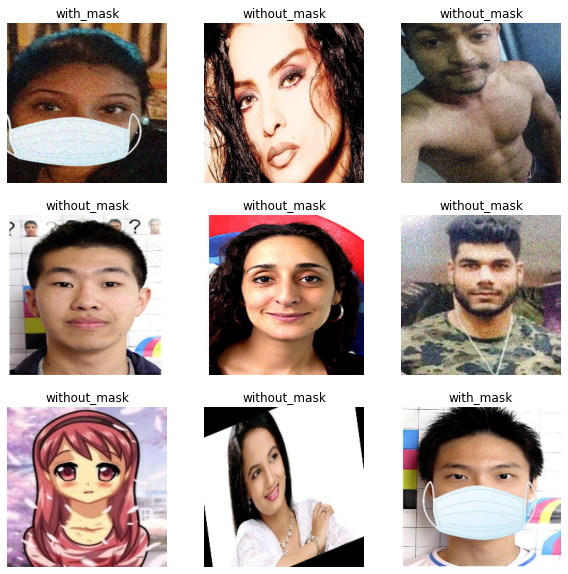

In [11]:
plt.figure(figsize=(10, 10))
for i, images in enumerate(X_train[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images)
    plt.title(list(class_mapping.keys())[np.argmax(y_train[i], axis=-1)])
    plt.axis("off")

plt.show()

# Partie 2 : Architecture CNN sur Tensorflow​


## Manipulation et l’exploitation de la Bibliothèque Tensorflow.

In [12]:
## Normalisation des données
normalization_layer = layers.Rescaling(1./255, input_shape = DEFAULT_INPUT_SHAPE)

## Data Augmentation
data_augmentation = ImageDataGenerator(
        rotation_range = 10,
        fill_mode="nearest",
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        zoom_range = 1.1,
        horizontal_flip = True
        )

data_augmentation.fit(X_train)


## Charger un modèle CNN à partir de Tensorflow.

In [13]:
## VGG16
cnn = VGG16(
    input_shape=DEFAULT_INPUT_SHAPE,
    include_top=False,
    weights='imagenet',
    classes=2)

# Partie 3 : Application


## Appliquer le Transfer Learning (sur VGG16).

In [14]:
for layer in cnn.layers:
  layer.trainable = False

## Classification
#classification_layer = models.Sequential(
#    [
#        layers.Flatten(),
#        layers.Dense(512, activation='relu'),
#        layers.Dense(2, activation='softmax'),
#    ],
#    name = "classification_layer"
#)

## Model
model = models.Sequential(
   [
       normalization_layer,
       cnn,
       layers.Flatten(),
       layers.Dense(512, activation='relu'),
       layers.Dense(2, activation='softmax'),
   ],
   name = "transfer_learning_model"
)

print(model.summary())

Model: "transfer_learning_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 27,561,282
Trainable params: 12,846,594
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [ ]:
model.compile(optimizer="adam",
              loss=losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

initial_epochs = 3

loss0, accuracy0 = model.evaluate(X_val, y_val, batch_size=32)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

checkpoint_filepath = '/tmp/checkpoint.hd5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(data_augmentation.flow(X_train, y_train),
                     epochs=initial_epochs,
                     validation_data=(X_val, y_val),
                     callbacks = [model_checkpoint_callback])

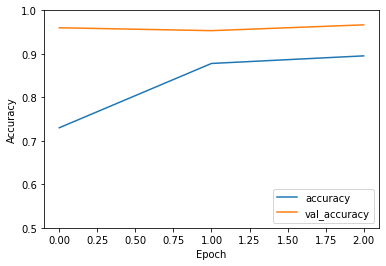

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_test = np.argmax(y_test, axis=-1)

print(y_pred)
print(y_test)

[0 0 0 1 1 1 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 0 0
 1 1 0 0 1 0 0 0 1 1 0 1 0 0 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1
 0 0 1 0 1 1 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 1 1 0 0 0 1 1 0 0 1 0 1 1 1
 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0 1 0 0 0 1 1 1 1 1 1 0 1 1 0
 0 0 1]
[0 0 0 1 1 1 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 0 0
 1 1 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1
 0 0 1 1 1 1 0 1 1 0 0 0 1 0 1 0 1 0 0 1 1 0 1 1 1 0 0 0 1 1 0 0 1 0 1 1 1
 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0 1 0 0 0 1 1 1 1 1 1 0 1 1 0
 0 0 1]


(151,)
(151,)


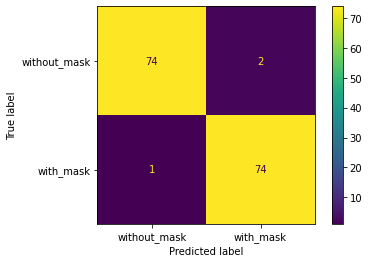

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print(y_pred.shape)
print(y_test.shape)

cm = confusion_matrix(y_pred, y_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()


In [ ]:
now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
path_model = WORKING_PATH
model.save(f"{path_model}-{now}.h5")


## Faire des tests à partir de la webcam

In [2]:
from  prediction import run_app

run_app()